# N.B.
- [ ] Create a class to save data into a file
- [ ] Check pauses into the codes and remove redundant ones (or add them if necessary).
- [ ] With sGen.pul_trig_mode(**'AUTO'**) there aren't errors, instead with sGen.pul_trig_mode(**'SING'**) (theorically more correct) the code stops working.  
    *-1074118634: The trigger has not occurred for the requested buffer, so data cannot be fetched relative to the trigger.*
- [ ] controllare se ad alte frequenze se le oscillazioni si vedono anche sull'oscilloscopio
- [ ] CHIEDERE RIGUARDO AI BATTIMENTI (ES SWEEP 39)



In [23]:
# Uscita trigger dal signal generator: Pulse Sync

%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *


ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

SMA100B: Connection successful!
5170R: Available communication!


# Setup parameters

In [24]:
# parameters for the Signal Generator
f_min           = 50e6                                  # tryout value
f_max           = 150e6                                  # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e6)          # Set range of frequency of the signal to send to the resonator
amplitude       = -10                           # Set the amplitude of the signal in dBm

pulse_width     = 2                                     # 2 microsec
pulse_delay     = 0
pulse_period    = 400  


sGen.reset()
sGen.clear()
sGen.RF_lvl_ampl(amplitude)
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')


# parameters for the Acquisition Card
pxie.voltage_range      = 2.0
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = 250e6 # Maximum Value: 250.0e6

pxie.open()


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)

# Acquisition of signals for each frequency in the range

In [25]:

slip = 0.0      # time of sleep of triggering

fetched_data = []

for i in pulse_freq:
    #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
    
    sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
    sGen.pul_state(1)
    sGen.RF_state(1)
    time.sleep(0.01)
    # wfm = pxie.acquisition(sGen.pul_exe_sing_trig,slip)
    wfm = pxie.acquisition(sGen.pul_exe_sing_trig)
    sGen.pul_state(0)
    sGen.RF_state(0)
    fetched_data += [{'freq': i, 'data': wfm[0].samples.tolist()}]

print('Number of sweeps:', len(fetched_data), '/', len(pulse_freq))


Number of sweeps: 100 / 100


# Plot of a sweep with the peaks of amplitudes marked

In [26]:
def data_amps(y: np.array, toggle_plot = True):
    x = np.arange(len(y))/pxie.sample_rate
    std = np.std(y)
    indices = find_peaks(y, prominence=2*(max(y) - std))
    idx = indices[0]
    offset = 5
    idx = idx[offset:-offset]
    
    if toggle_plot:
        plt.clf()
        plt.grid()
        plt.plot(x, y)
        plt.scatter(x[idx],y[idx], color = 'orange')
        plt.show()
    return {'mean': np.mean(y[idx]), 'std' : np.std(y[idx])}

In [27]:
# n_sweep = 19

# f_chosen = fetched_data[n_sweep]
# print('freq:', f_chosen['freq'])
# y = np.array(f_chosen['data'])
# data_amps(y)
# std = np.std(y)
# indices = find_peaks(y, prominence=2*(max(y) - std))

# # print('mean', np.mean(y[indices[0]]))

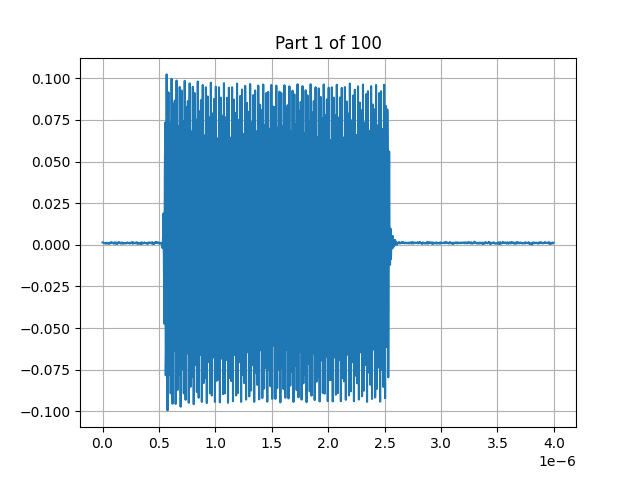

In [28]:
sweep = 0
x = np.arange(len(y))/pxie.sample_rate
def on_key(event):
    global sweep
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    if (sweep+1) > len(fetched_data) or sweep == -1:
        sweep = 0


    f_chosen = fetched_data[sweep]
    y = np.array(f_chosen['data'])
    std = np.std(y)
    indices = find_peaks(y, prominence=2*(max(y) - std))
    idx = indices[0]
    offset = 5
    idx = idx[offset:-offset]
    # clear frame
    plt.clf()
    plt.title(f'Part {sweep+1} of {len(fetched_data)}')
    plt.grid()
    plt.plot(x, y)
    plt.scatter(x[idx],y[idx], color = 'orange')
    plt.draw() # redraw

fig,ax=plt.subplots()
plt.title(f'Part {sweep+1} of {len(fetched_data)}')
plt.plot(x, y)
fig.canvas.mpl_connect('key_press_event',on_key)
plt.grid()
plt.show()
plt.draw()

# Save data on HDF5 file

In [29]:
# with h5py.File('nonloso_2.hdf5', 'a') as f:                      # creo file hdf5 di nome tra virgolette e lo apro in modalità a = appen
#     for j in range(0, len(fetched_data)):
#         gp_data = f.create_group(str(j))
#         freq, data = fetched_data[j].items()
#         gp_data.create_dataset(str(freq[0]), data = freq[1])
#         gp_data.create_dataset(str(data[0]), data = data[1])

# Read data from HDF5 file

In [30]:
# with h5py.File('nonloso.hdf5', 'r') as f:
#     idx = 4
#     gp = f[str(idx)]
#     dic = {}
#     for i, k in gp.items():
#         dic[i] = k[()]
# freq = dic['freq']
# data = dic['data']
# plt.clf()
# data_plot(data)

# plt.show()


# First Data Analysis tryout

In [31]:
# offset = 2.5e-6
# end = 5e-6

# with h5py.File('nonloso.hdf5', 'r'):
    

In [32]:
# amps = []
# with h5py.File('nonloso_2.hdf5', 'r') as f:
#     for j in range(1,len(f)):
#         gp = f[str(j)]
#         dic = {}
#         for i, k in gp.items():
#             dic[i] = k[()]
#         freq = dic['freq']
#         data = dic['data']

            
#         amps = amps + [data_amps(data, False)['mean']]


# plt.clf()
# plt.plot(amps)
# plt.show()